In [298]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [300]:
import feature_string as feature_string
import feature_num as feature_num
import feature_categorica as feature_categorica
import common_machine_learning as common
import my_pipeline as my_pipe

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin

from hyperopt import fmin, tpe, hp, STATUS_OK

from xgboost import XGBRegressor

import time

import nltk
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords

import re

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Constates

In [0]:
TARGET = 'precio'
K = 3
RANDOM_SEMILLA = 3 # numero favorito (de la suerte)
N_ITER = 15

## Train

In [0]:
train = common.cargar_set_optimizado('/content/drive/My Drive/Colab Notebooks/sets_de_datos/train.csv')

## Features

In [0]:
def limpiar(df):
    df['garages'] = df['garages'].fillna(0)
    df['metroscubiertos'] = df['metroscubiertos'].fillna(df.metroscubiertos.mean())
    df['antiguedad'] = df['antiguedad'].fillna(df.antiguedad.mean())
    df['banos'] = df['banos'].fillna(1)
    df['habitaciones'] = df['habitaciones'].fillna(df.habitaciones.mean())
    df['tipodepropiedad'] = df['tipodepropiedad'].fillna('Casa')
    df['metrostotales'] = df['metrostotales'].fillna(df['metrostotales'].mean())
    df['metroscubiertos'] = df['metroscubiertos'].fillna(df['metroscubiertos'].mean())
    df['ciudad'] = df['ciudad'].fillna("")

def nuevas_features(df, precios_tipo,precio_m2,promedios,default_m2):
    df['ratio_cubierto'] = df.apply(lambda x: x['metroscubiertos']/x['metrostotales'] if x['metrostotales'] else 1, axis = 1)
    df['tipodepropiedad_precio_mean'] = df['tipodepropiedad'].apply(lambda x: precios_tipo.loc[x]['precio_por_tipo'])
    df['precio_x_m2'] = df.apply(lambda x: precio_x_m2.get(x['ciudad'],default_m2), axis = 1)
    df['mean_hab'] = df.apply(lambda x: promedios['mean_hab'].get(x['ciudad'],default_m2), axis = 1)
    df['mean_ban'] = df.apply(lambda x: promedios['mean_ban'].get(x['ciudad'],default_m2), axis = 1)
    df['mean_gar'] = df.apply(lambda x: promedios['mean_gar'].get(x['ciudad'],default_m2), axis = 1)
    df['cantidad_extras'] = df['gimnasio'].astype(int) + df['usosmultiples'].astype(int)\
                            + df['piscina'].astype(int) + df['escuelascercanas'].astype(int)\
                            + df['centroscomercialescercanos'].astype(int)

In [0]:
limpiar(train)

In [0]:
train_precios_por_tipo = train.groupby('tipodepropiedad').agg({'precio':'mean'}).rename(columns={'precio':'precio_por_tipo'})
train['precio_x_m2'] = train['precio']/train['metroscubiertos']
precio_x_m2 = train.groupby('ciudad').agg({'precio_x_m2':'mean'}).to_dict()['precio_x_m2']
default_m2 = train.groupby('ciudad').agg({'precio_x_m2':'mean'})['precio_x_m2'].mean()
promedios = train.set_index('ciudad')\
            .join(train.groupby('ciudad')\
                  .agg({'habitaciones':'mean', 'garages':'mean', 'banos':'mean'})\
                      .rename(columns={'habitaciones':'mean_hab', 'banos':'mean_ban', 'garages':'mean_gar'}))\
                        [['mean_hab','mean_gar','mean_ban']].to_dict()

In [0]:
nuevas_features(train, train_precios_por_tipo, precio_x_m2, promedios, default_m2)

In [0]:
train = feature_num.completar_lat_lng_con_provincias_y_ciudades(train)
train = feature_num.completar_lat_lng_con_idzona_mean(train)
feature_num.completar_lat_lng_con_promedio_Mexico(train)

In [0]:
feature_num.agregar_feature_fecha_numerica(train)

In [0]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
stop_words = stop_words_sp | stop_words_en

In [0]:
train['descripcion'] = train['descripcion'].fillna('e')\
    .map(lambda x: remove_tags(str(x)))\
    .map(lambda x: "".join([letra.lower() for letra in x if letra.isalpha() or letra == ' ']))\
    .map(lambda x: " ".join([palabra for palabra in x.split() if palabra not in stop_words_sp and len(palabra)>2]))

In [0]:
train['precio_categorico'] = train['precio'] /10000

In [0]:
def categorizar_precio(precio):
    categorias = [100,200,300,400,500]
    for i in range(len(categorias)):
        if precio < categorias[i]:
            return i
    return 4

In [0]:
train['categoria_descripcion'] = train['precio_categorico'].transform(lambda x: categorizar_precio(x))

In [0]:
train = train.drop(['precio_categorico'], axis = 1)

In [0]:
class ClasificarDescripcionMultinomialNB(BaseEstimator, TransformerMixin):
    """
    a general class for creating a machine learning step in the machine learning pipeline
    """
    def __init__(self, nombre_string, nombre_categoria):
        """
        constructor
        """
        self.clasificador = MultinomialNB()
        self.count_vec = CountVectorizer()
        self.tf_idf_transformer = TfidfTransformer()
        self.nombre_string = str(nombre_string)
        self.nombre_categoria = str(nombre_categoria)

    def fit(self, X, y=None, **kwargs):
        """
        an abstract method that is used to fit the step and to learn by examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer - Transformer
        """
        X_descripcion_counts = self.count_vec.fit_transform(X[self.nombre_string])
        X_descripcion_tfidf = self.tf_idf_transformer.fit_transform(X_descripcion_counts)
        self.clasificador.fit(X_descripcion_tfidf, X[self.nombre_categoria])
        return self

    def transform(self, X, y=None, **kwargs):
        """
        an abstract method that is used to transform according to what happend in the fit method
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        X_descripcion_counts = self.count_vec.transform(X[self.nombre_string])
        X_descripcion_tfidf = self.tf_idf_transformer.transform(X_descripcion_counts)
        out = X.copy()
        out[self.nombre_categoria] = self.clasificador.predict(X_descripcion_tfidf)
        return out

    def fit_transform(self, X, y=None, **kwargs):
        """
        perform fit and transform over the data
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        self = self.fit(X, y)
        return self.transform(X, y)

In [0]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    a general class for creating a machine learning step in the machine learning pipeline
    """
    def __init__(self, lista_nombre_col):
        """
        constructor
        """
        self.lista_nombre_col = lista_nombre_col

    def fit(self, X, y=None, **kwargs):
        """
        an abstract method that is used to fit the step and to learn by examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer - Transformer
        """
        return self

    def transform(self, X, y=None, **kwargs):
        """
        an abstract method that is used to transform according to what happend in the fit method
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        out = X.copy()
        for col in self.lista_nombre_col:
          if col in X.columns:
            out = out.drop([col], axis = 1)
        return out

    def fit_transform(self, X, y=None, **kwargs):
        """ValueError: DataFrame for label cannot have multiple columns
        perform fit and transform over the data
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        self = self.fit(X, y)
        return self.transform(X, y) 


In [0]:
FEATURES = [
            'tipodepropiedad_precio_mean', 
            'lat', 
            'lng', 
            'garages', 
            'habitaciones', 
            'antiguedad', 
            'metroscubiertos', 
            'banos', 
            'ratio_cubierto', 
            'mean_hab', 
            'mean_ban', 
            'mean_gar', 
            'precio_x_m2',
            'cantidad_extras',
            'fecha_numerica', 
            'descripcion',
            'categoria_descripcion',
            'precio'
            ]

In [0]:
train.set_index('id', inplace = True)

In [0]:
train = train[FEATURES]

In [321]:
train.columns

Index(['tipodepropiedad_precio_mean', 'lat', 'lng', 'garages', 'habitaciones',
       'antiguedad', 'metroscubiertos', 'banos', 'ratio_cubierto', 'mean_hab',
       'mean_ban', 'mean_gar', 'precio_x_m2', 'cantidad_extras',
       'fecha_numerica', 'descripcion', 'categoria_descripcion', 'precio'],
      dtype='object')

## X & y

In [0]:
X = train.drop([TARGET], axis = 1).copy()
y = train[TARGET].copy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Pipeline Test

In [0]:
test_pipe = Pipeline(steps = [
                              ('clasificar_descripciones', ClasificarDescripcionMultinomialNB('descripcion', 'categoria_descripcion')),
                              ('drop_columns', DropColumns(['descripcion'])),
                              ('regressor', XGBRegressor(
                                                  objective = 'reg:squarederror',
                                                  colsample_bytree = 0.8,  
                                                  gamma = 2.437274196898383,  
                                                  reg_lambda = 1.898384883119414,  
                                                  learning_rate = 0.02569446898167743,  
                                                  max_depth = 10,  
                                                  min_child_weight = 3,  
                                                  n_estimators = 941,  
                                                  subsample = 0.79  
                                                        ))
])

In [0]:
def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Performance del modelo:')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [326]:
test_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('clasificar_descripciones',
                 ClasificarDescripcionMultinomialNB(nombre_categoria='categoria_descripcion',
                                                    nombre_string='descripcion')),
                ('drop_columns', DropColumns(lista_nombre_col=['descripcion'])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8, gamma=2.437274196898383,
                              importance_type='gain',
                              learning_rate=0.02569446898167743,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=3, missing=None,
                              n_estimators=941, n_jobs=1, nthread=None,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=

In [327]:
evaluar_modelo(test_pipe, X_test, y_test)

Performance del modelo:
Average Error: 547295.3125 degrees.
Accuracy = 73.59%.


73.59280586242676

Text(0, 0.5, 'Feature Importance Score')

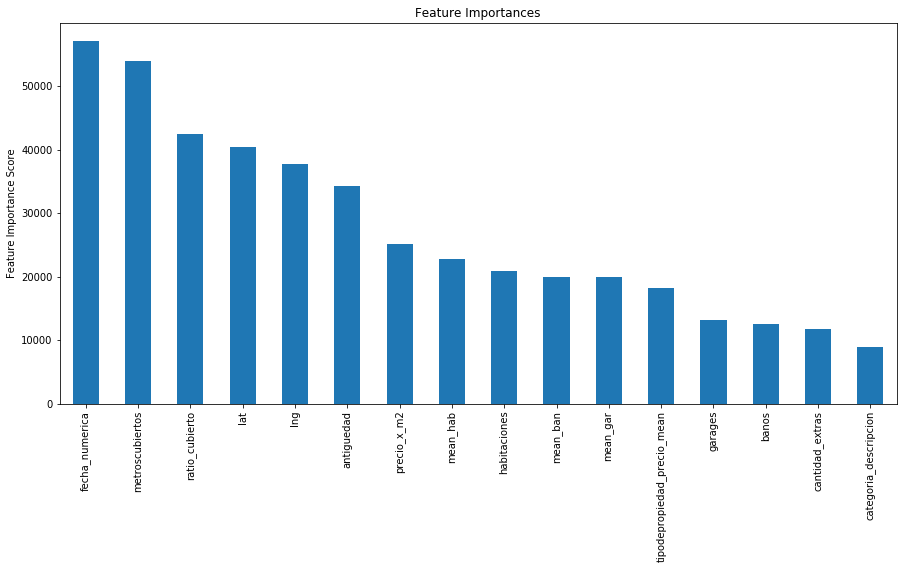

In [328]:
feat_imp = pd.Series(test_pipe['regressor'].get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(15, 7))
plt.ylabel('Feature Importance Score')

## Objective, Space & Pipeline 

In [0]:
def objective(hyper_parametros):

    tuneo_pipe = Pipeline(steps = [
                              ('clasificar_descripciones', ClasificarDescripcionMultinomialNB('descripcion', 'categoria_descripcion')),
                              ('drop_columns', DropColumns(['descripcion'])),
                              ('regressor', XGBRegressor(objective = 'reg:squarederror', **hyper_parametros))
                  ])
    
    score = cross_val_score(tuneo_pipe, X, y, scoring='neg_mean_absolute_error', cv=K).mean()
    
    print("SCORE: {:.3f} params {}".format(score, hyper_parametros))
    
    return {'loss': -score, 'status': STATUS_OK}

In [0]:
space = {
    "n_estimators": hp.randint("n_estimators", 400) + 600, 
    "learning_rate": hp.uniform("learning_rate", 0.005, 0.03), 
    "gamma": hp.uniform("gamma", 0.1, 5),
    "lambda": hp.uniform("lambda",0.1, 5),
    "max_depth": hp.randint("max_depth", 3) + 8, 
    "subsample": 0.79,
    "colsample_bytree": 0.8,
    "min_child_weight": hp.randint("min_child_weight", 3) + 2
}

## Tunning

In [0]:
t0 = time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=N_ITER)
t1 = time.time()
print('Tiempo = {0:.2f} minutos'.format((t1 - t0)/60))

  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

In [0]:
print(best)

## Ultimo mejor resultado

-568413.688 params  
{  
  'colsample_bytree': 0.8,  
  'gamma': 2.437274196898383,  
  'lambda': 1.898384883119414,  
  'learning_rate': 0.02569446898167743,  
  'max_depth': 10,  
  'min_child_weight': 3,  
  'n_estimators': 941,  
  'subsample': 0.79  
}